# FeatCopilot Demo: LLM-Powered Auto Feature Engineering

This notebook demonstrates the key capabilities of **FeatCopilot**, a next-generation feature engineering framework:

1. **Tabular Feature Engineering** - Automated feature generation with mathematical transformations
2. **LLM-Powered Features** - Semantic understanding and domain-aware feature creation
3. **Feature Store Integration** - Save and serve features with Feast
4. **AutoML Training** - Train models with FLAML using engineered features

---

## 1. Setup & Imports

In [ ]:
# Install dependencies (uncomment if needed)

%pip install featcopilot[full] matplotlib seaborn -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import mlflow
mlflow.autolog(disable=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Libraries loaded")

✓ Libraries loaded


In [3]:
# Import FeatCopilot
from featcopilot import AutoFeatureEngineer
from featcopilot.engines import TabularEngine
from featcopilot.selection import FeatureSelector

# Try to import LLM components
try:
    from featcopilot.llm import SemanticEngine
    LLM_AVAILABLE = True
    print("✓ FeatCopilot with LLM support")
except ImportError:
    LLM_AVAILABLE = False
    print("✓ FeatCopilot loaded (LLM support not installed)")

✓ FeatCopilot with LLM support


In [4]:
# ============================================
# LLM CONFIGURATION
# ============================================
# Backend options:
#   - 'litellm': Use LiteLLM (supports 100+ providers)
#   - 'copilot': Use GitHub Copilot SDK
#
# Model options (depend on backend):
#   LiteLLM: 'gpt-4o', 'github/gpt-4o', 'azure/gpt-4o', 'anthropic/claude-3-5-sonnet'
#   Copilot: 'gpt-4o', 'gpt-4', 'claude-3.5-sonnet'

LLM_BACKEND = 'openai'  # 'litellm' or 'copilot'
LLM_MODEL = 'gpt-5.1'     # Model name (provider-specific for litellm)

import os
if LLM_AVAILABLE:
    # Check for API keys based on backend
    if LLM_BACKEND == 'copilot':
        print(f'✓ Using Copilot backend with model: {LLM_MODEL}')
    elif 'OPENAI_API_KEY' in os.environ:
        print(f'✓ Using LiteLLM backend with model: {LLM_MODEL} (OPENAI_API_KEY found)')
    elif 'GITHUB_API_KEY' in os.environ:
        LLM_MODEL = 'github/gpt-5.2'
        print(f'✓ Using LiteLLM backend with model: {LLM_MODEL} (GITHUB_API_KEY found)')
    else:
        print('⚠ No API key found. LLM features will use mock responses.')
        print('  Set OPENAI_API_KEY, GITHUB_API_KEY, or use copilot backend.')

✓ Using LiteLLM backend with model: gpt-5.1 (OPENAI_API_KEY found)


## 2. Dataset: Healthcare Diabetes Prediction

We'll use a synthetic healthcare dataset where feature engineering provides significant benefits.
The target depends on **interactions and ratios** between features that simple models can't easily learn.

In [5]:
def create_diabetes_dataset(n_samples=2000, random_state=42):
    """
    Create a synthetic diabetes dataset where feature engineering matters.
    The target is based on medical ratios and XOR-like interactions that
    linear models cannot capture without engineered features.
    """
    np.random.seed(random_state)
    
    data = pd.DataFrame({
        'patient_id': range(1, n_samples + 1),
        'event_timestamp': [datetime.now() - timedelta(days=np.random.randint(0, 365)) 
                           for _ in range(n_samples)],
        # Demographics
        'age': np.random.randint(25, 85, n_samples),
        'bmi': np.random.normal(28, 6, n_samples).clip(16, 50),
        # Blood pressure
        'bp_systolic': np.random.normal(130, 20, n_samples).clip(90, 200),
        'bp_diastolic': np.random.normal(85, 12, n_samples).clip(60, 120),
        # Cholesterol
        'cholesterol_total': np.random.normal(220, 45, n_samples).clip(120, 350),
        'cholesterol_hdl': np.random.normal(50, 15, n_samples).clip(25, 100),
        # Glucose markers
        'glucose_fasting': np.random.normal(110, 35, n_samples).clip(70, 250),
        'hba1c': np.random.normal(6.0, 1.5, n_samples).clip(4, 14),
        # Lifestyle
        'smoking_years': np.random.exponential(8, n_samples).clip(0, 50),
        'exercise_hours_weekly': np.random.exponential(3, n_samples).clip(0, 20),
    })
    
    # Create target based on INTERACTIONS and RATIOS that linear models CAN'T capture
    # Key insight: XOR-like patterns and threshold crossings require feature engineering
    
    # 1. Glucose-HbA1c interaction (diabetes indicators should correlate)
    glucose_high = (data['glucose_fasting'] > 126).astype(float)
    hba1c_high = (data['hba1c'] > 6.5).astype(float)
    glucose_hba1c_match = (glucose_high == hba1c_high).astype(float)  # Both high or both normal
    
    # 2. BMI-Age risk (obesity is riskier at older age)
    bmi_age_risk = (data['bmi'] > 30) & (data['age'] > 50)
    
    # 3. Cholesterol ratio (key medical indicator)
    chol_ratio = data['cholesterol_total'] / (data['cholesterol_hdl'] + 1)
    bad_chol_ratio = (chol_ratio > 5).astype(float)
    
    # 4. Blood pressure - pulse pressure (systolic - diastolic)
    pulse_pressure = data['bp_systolic'] - data['bp_diastolic']
    high_pulse_pressure = (pulse_pressure > 60).astype(float)
    
    # 5. Lifestyle protection (exercise counteracts smoking)
    lifestyle_risk = np.where(
        data['exercise_hours_weekly'] > 5,
        data['smoking_years'] * 0.5,  # Exercise reduces smoking risk
        data['smoking_years'] * 1.5   # No exercise amplifies smoking risk
    )
    
    # Combine factors - target depends on NON-LINEAR interactions
    # XOR and AND patterns that require feature engineering for linear models
    risk_score = (
        -3.0
        + 2.5 * (1 - glucose_hba1c_match)  # XOR: discordant glucose/hba1c is very concerning
        + 1.5 * bmi_age_risk.astype(float)  # AND: obesity + older age compounds risk
        + 1.2 * bad_chol_ratio * high_pulse_pressure  # AND: bad cholesterol ratio + high pulse pressure
        + 1.0 * (data['smoking_years'] > 10).astype(float) * (data['exercise_hours_weekly'] < 3).astype(float)  # AND: heavy smoker + sedentary
        + 0.03 * lifestyle_risk  # Exercise moderates smoking impact
    )
    
    # Add small noise
    risk_score += np.random.normal(0, 0.3, n_samples)
    
    # Convert to probability and binary outcome
    prob = 1 / (1 + np.exp(-risk_score))
    data['diabetes'] = (np.random.random(n_samples) < prob).astype(int)
    
    return data

# Create dataset
data = create_diabetes_dataset(2000)
print(f"Dataset shape: {data.shape}")
print(f"Target distribution:\n{data['diabetes'].value_counts()}")
data.head()

Dataset shape: (2000, 13)
Target distribution:
diabetes
0    1341
1     659
Name: count, dtype: int64


,patient_id,event_timestamp,age,bmi,bp_systolic,bp_diastolic,cholesterol_total,cholesterol_hdl,glucose_fasting,hba1c,smoking_years,exercise_hours_weekly,diabetes
0,1,2025-11-02 14:38:15.530025,52,23.928824,117.185365,89.603790,325.866329,47.347173,127.847479,5.887874,2.962818,4.532943,0
1,2,2025-03-01 14:38:15.530066,71,28.454034,200.000000,89.547768,149.155184,65.368426,130.243534,4.000000,4.451262,1.168756,0
2,3,2025-05-18 14:38:15.530072,39,25.830128,137.235715,93.246007,158.309619,61.320100,115.346109,5.951423,4.274249,1.686481,0
3,4,2025-10-29 14:38:15.530075,30,39.807394,151.688592,80.434091,251.170242,50.927586,143.265395,6.847835,12.050877,1.958794,0
4,5,2025-12-03 14:38:15.530078,68,28.112682,109.541090,79.779379,273.220602,49.122072,151.003224,4.852136,2.653879,7.825822,0


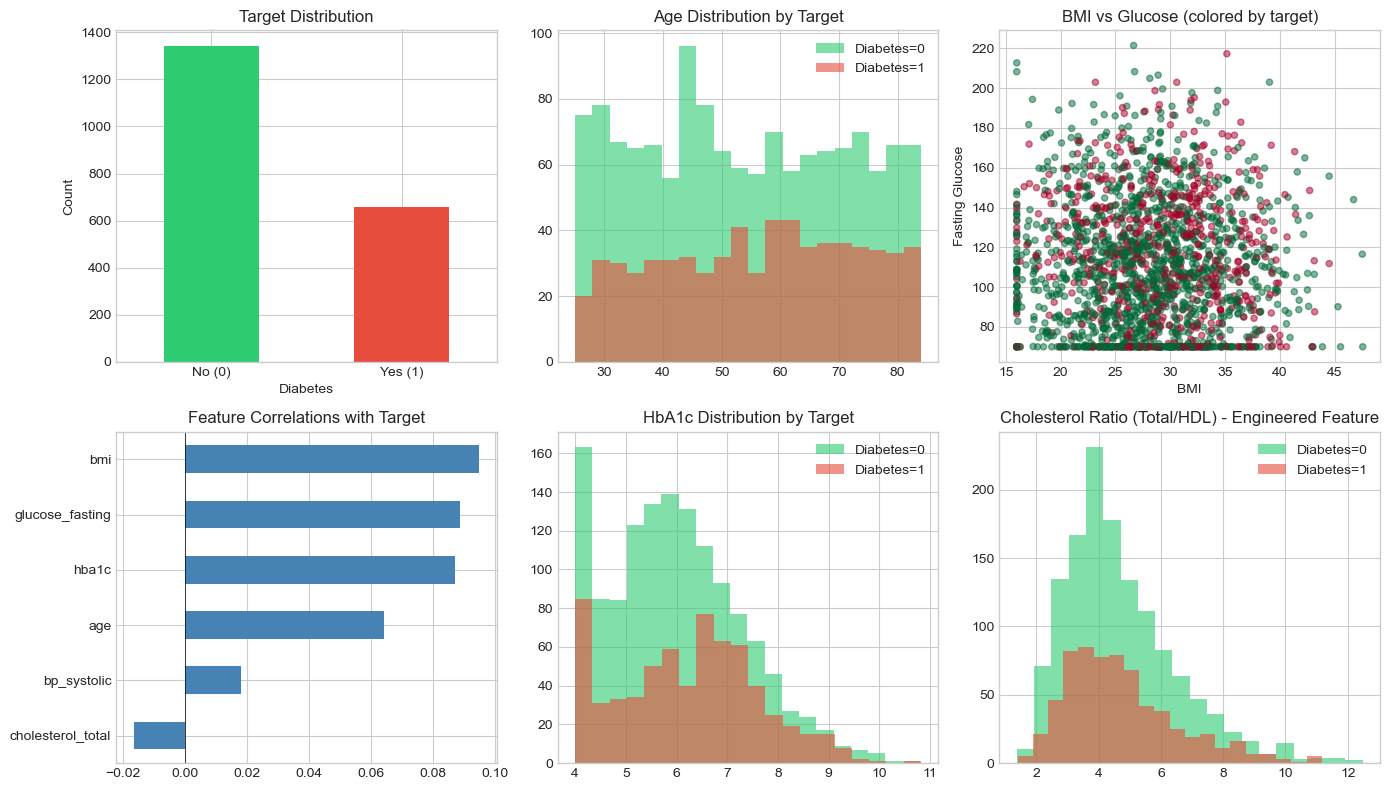


💡 Notice: Individual features have weak correlations with the target.
   The target depends on NON-LINEAR interactions (thresholds, XOR patterns) that require feature engineering!


In [6]:
# Visualize the dataset
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Target distribution
ax = axes[0, 0]
data['diabetes'].value_counts().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
ax.set_title('Target Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Diabetes')
ax.set_ylabel('Count')
ax.set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

# Age distribution by target
ax = axes[0, 1]
for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
    data[data['diabetes'] == label]['age'].hist(ax=ax, alpha=0.6, label=f'Diabetes={label}', color=color, bins=20)
ax.set_title('Age Distribution by Target', fontsize=12, fontweight='bold')
ax.legend()

# BMI vs Glucose
ax = axes[0, 2]
scatter = ax.scatter(data['bmi'], data['glucose_fasting'], c=data['diabetes'], 
                     cmap='RdYlGn_r', alpha=0.5, s=20)
ax.set_xlabel('BMI')
ax.set_ylabel('Fasting Glucose')
ax.set_title('BMI vs Glucose (colored by target)', fontsize=12, fontweight='bold')

# Correlation with target
ax = axes[1, 0]
feature_cols = ['age', 'bmi', 'bp_systolic', 'cholesterol_total', 'glucose_fasting', 'hba1c']
correlations = data[feature_cols + ['diabetes']].corr()['diabetes'].drop('diabetes').sort_values()
correlations.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Feature Correlations with Target', fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# HbA1c distribution
ax = axes[1, 1]
for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
    data[data['diabetes'] == label]['hba1c'].hist(ax=ax, alpha=0.6, label=f'Diabetes={label}', color=color, bins=20)
ax.set_title('HbA1c Distribution by Target', fontsize=12, fontweight='bold')
ax.legend()

# Feature importance hint: show that ratios matter
ax = axes[1, 2]
data['chol_ratio_temp'] = data['cholesterol_total'] / (data['cholesterol_hdl'] + 1)
for label, color in [(0, '#2ecc71'), (1, '#e74c3c')]:
    data[data['diabetes'] == label]['chol_ratio_temp'].hist(ax=ax, alpha=0.6, label=f'Diabetes={label}', color=color, bins=20)
ax.set_title('Cholesterol Ratio (Total/HDL) - Engineered Feature', fontsize=12, fontweight='bold')
ax.legend()
data.drop('chol_ratio_temp', axis=1, inplace=True)

plt.tight_layout()
plt.savefig('dataset_exploration.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n💡 Notice: Individual features have weak correlations with the target.")
print("   The target depends on NON-LINEAR interactions (thresholds, XOR patterns) that require feature engineering!")

## 3. Prepare Data for Modeling

In [7]:
# Define feature columns and column descriptions for LLM
feature_cols = [
    'age', 'bmi', 'bp_systolic', 'bp_diastolic',
    'cholesterol_total', 'cholesterol_hdl',
    'glucose_fasting', 'hba1c',
    'smoking_years', 'exercise_hours_weekly'
]

# Column descriptions help the LLM understand the data
column_descriptions = {
    'age': 'Patient age in years',
    'bmi': 'Body Mass Index (kg/m²)',
    'bp_systolic': 'Systolic blood pressure in mmHg',
    'bp_diastolic': 'Diastolic blood pressure in mmHg',
    'cholesterol_total': 'Total cholesterol in mg/dL',
    'cholesterol_hdl': 'HDL (good) cholesterol in mg/dL',
    'glucose_fasting': 'Fasting blood glucose in mg/dL',
    'hba1c': 'Hemoglobin A1c percentage (3-month glucose average)',
    'smoking_years': 'Number of years patient has smoked',
    'exercise_hours_weekly': 'Average hours of exercise per week',
}

# Split data
X = data[feature_cols].copy()
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1600, 10)
Test set: (400, 10)


## 4. Baseline Model (No Feature Engineering)

In [8]:
# Train baseline model
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

baseline_pred = baseline_model.predict(X_test)
baseline_prob = baseline_model.predict_proba(X_test)[:, 1]

baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_auc = roc_auc_score(y_test, baseline_prob)

print("="*50)
print("BASELINE MODEL (No Feature Engineering)")
print("="*50)
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC:  {baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_pred, target_names=['No Diabetes', 'Diabetes']))

BASELINE MODEL (No Feature Engineering)
Accuracy: 0.7075
ROC-AUC:  0.6958

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.72      0.93      0.81       268
    Diabetes       0.65      0.25      0.36       132

    accuracy                           0.71       400
   macro avg       0.68      0.59      0.59       400
weighted avg       0.69      0.71      0.66       400



## 5. Feature Engineering with FeatCopilot

### 5.1 Tabular Engine (Fast Mode)

In [9]:
%%time
# Tabular Engine - generates polynomial features, interactions, and transformations
tabular_engineer = AutoFeatureEngineer(
    engines=['tabular'],
    max_features=50,
    verbose=True
)

X_train_tabular = tabular_engineer.fit_transform(X_train, y_train)
X_test_tabular = tabular_engineer.transform(X_test)

# Align columns
common_cols = [c for c in X_train_tabular.columns if c in X_test_tabular.columns]
X_train_tabular = X_train_tabular[common_cols].fillna(0)
X_test_tabular = X_test_tabular[common_cols].fillna(0)

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Tabular features: {X_train_tabular.shape[1]}")
print(f"\nNew features generated: {X_train_tabular.shape[1] - X_train.shape[1]}")


Original features: 10
Tabular features: 45

New features generated: 35
CPU times: user 1.62 s, sys: 63.2 ms, total: 1.68 s
Wall time: 1.81 s


In [10]:
# Show some generated features
new_features = [c for c in X_train_tabular.columns if c not in feature_cols][:15]
print("Sample generated features:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

Sample generated features:
  1. bp_systolic_x_smoking_years
  2. cholesterol_total_x_smoking_years
  3. glucose_fasting_x_hba1c
  4. age_x_smoking_years
  5. smoking_years_pow2
  6. age_x_bp_diastolic
  7. bp_systolic_x_glucose_fasting
  8. age_x_bmi
  9. cholesterol_total_x_hba1c
  10. bmi_x_hba1c
  11. exercise_hours_weekly_pow2
  12. bp_diastolic_x_glucose_fasting
  13. bp_systolic_x_hba1c
  14. age_x_cholesterol_total
  15. bmi_x_glucose_fasting


### 5.2 LLM Engine (Semantic Understanding)

In [11]:
%%time
# LLM Engine - uses semantic understanding to generate domain-aware features
LLM_SUCCESS = False
if LLM_AVAILABLE:
    try:
        llm_engineer = AutoFeatureEngineer(
            engines=['tabular', 'llm'],
            max_features=60,
            llm_config={
                'model': LLM_MODEL,
                'backend': LLM_BACKEND,
                'max_suggestions': 15,
                'domain': 'healthcare',
                'validate_features': True,
            },
            verbose=True
        )

        X_train_llm = llm_engineer.fit_transform(
            X_train, y_train,
            column_descriptions=column_descriptions,
            task_description="Predict Type 2 diabetes risk based on patient health metrics"
        )
        X_test_llm = llm_engineer.transform(X_test)

        # Align columns
        common_cols_llm = [c for c in X_train_llm.columns if c in X_test_llm.columns]
        X_train_llm = X_train_llm[common_cols_llm].fillna(0)
        X_test_llm = X_test_llm[common_cols_llm].fillna(0)
        LLM_SUCCESS = True

        print(f"\nOriginal features: {X_train.shape[1]}")
        print(f"LLM-enhanced features: {X_train_llm.shape[1]}")
    except Exception as e:
        print(f"⚠ LLM engine failed: {e}")
        print("Falling back to tabular features.")
        LLM_AVAILABLE = False

if not LLM_AVAILABLE or not LLM_SUCCESS:
    # Use tabular features as LLM features when LLM not available
    X_train_llm = X_train_tabular.copy()
    X_test_llm = X_test_tabular.copy()
    llm_engineer = tabular_engineer
    print("Using tabular features (LLM not available or failed).")

2026-02-12 14:38:21,849 - featcopilot.engines.tabular - INFO - tabular.py:154 - TabularEngine: Found 10 numeric columns
2026-02-12 14:38:21,852 - featcopilot.engines.tabular - INFO - tabular.py:316 - TabularEngine: Planned 175 features
2026-02-12 14:38:21,852 - featcopilot.transformers.sklearn_compat - INFO - sklearn_compat.py:189 - Fitted tabular engine
2026-02-12 14:38:22,790 - featcopilot.llm.openai_client - INFO - openai_client.py:121 - Using Microsoft Fabric credentials for OpenAI
2026-02-12 14:38:22,790 - featcopilot.llm.openai_client - INFO - openai_client.py:128 - OpenAI client started with model: gpt-5.1
2026-02-12 14:38:22,791 - featcopilot.llm.semantic_engine - INFO - semantic_engine.py:219 - SemanticEngine: Detected 0 text columns: []
2026-02-12 14:38:22,794 - featcopilot.llm.semantic_engine - INFO - semantic_engine.py:229 - SemanticEngine: Requesting feature suggestions from LLM...



Original features: 10
LLM-enhanced features: 56
CPU times: user 2.48 s, sys: 200 ms, total: 2.68 s
Wall time: 13.2 s


In [12]:
# Get feature explanations from LLM
explanations = llm_engineer.explain_features()

print("\n" + "="*60)
print("FEATURE EXPLANATIONS")
print("="*60)
if explanations:
    for i, (name, explanation) in enumerate(list(explanations.items())[:8], 1):
        print(f"\n{i}. {name}")
        print(f"   {explanation[:150]}..." if len(explanation) > 150 else f"   {explanation}")
else:
    print("No explanations available.")


FEATURE EXPLANATIONS

1. age_pow2
   age raised to power 2

2. bmi_pow2
   bmi raised to power 2

3. bp_systolic_pow2
   bp_systolic raised to power 2

4. bp_diastolic_pow2
   bp_diastolic raised to power 2

5. cholesterol_total_pow2
   cholesterol_total raised to power 2

6. cholesterol_hdl_pow2
   cholesterol_hdl raised to power 2

7. glucose_fasting_pow2
   glucose_fasting raised to power 2

8. hba1c_pow2
   hba1c raised to power 2


In [13]:
# Get generated feature code (only available with LLM engine)
feature_code = llm_engineer.get_feature_code()

print("\n" + "="*60)
print("GENERATED FEATURE CODE")
print("="*60)
if feature_code:
    for i, (name, code) in enumerate(list(feature_code.items())[:5], 1):
        print(f"\n# {i}. {name}")
        print(f"{code}")
else:
    print("Feature code only available with LLM engine.")


GENERATED FEATURE CODE

# 1. pulse_pressure
result = df['bp_systolic'] - df['bp_diastolic']

# 2. mean_arterial_pressure
result = df['bp_diastolic'] + (df['bp_systolic'] - df['bp_diastolic']) / 3.0

# 3. bmi_age_interaction
result = df['bmi'] * df['age']

# 4. bmi_squared
result = df['bmi'] ** 2

# 5. non_hdl_cholesterol
result = df['cholesterol_total'] - df['cholesterol_hdl']


## 6. Visualize Feature Engineering Results

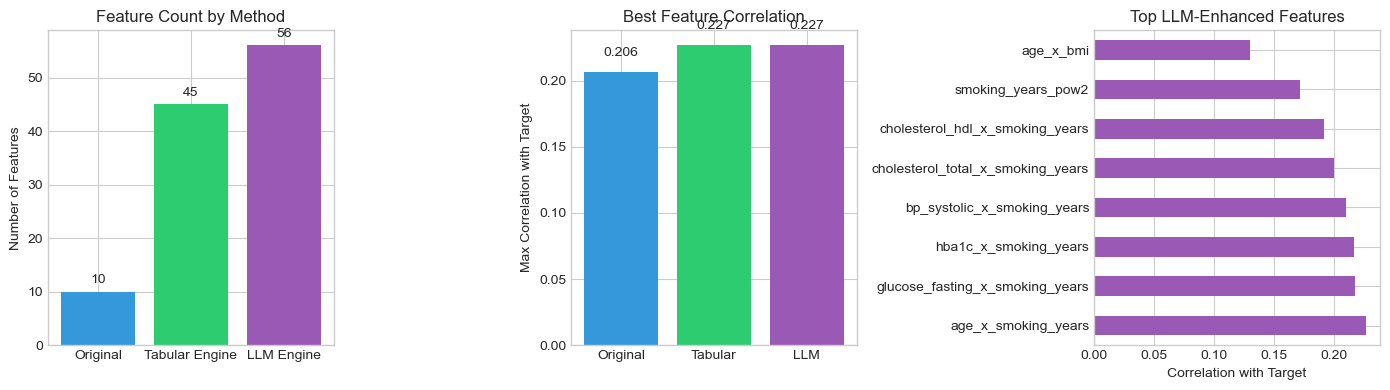

In [14]:
# Compare feature counts
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Feature count comparison
ax = axes[0]
feature_counts = {
    'Original': X_train.shape[1],
    'Tabular Engine': X_train_tabular.shape[1],
    'LLM Engine': X_train_llm.shape[1]
}
bars = ax.bar(feature_counts.keys(), feature_counts.values(), color=['#3498db', '#2ecc71', '#9b59b6'])
ax.set_ylabel('Number of Features')
ax.set_title('Feature Count by Method', fontsize=12, fontweight='bold')
for bar, count in zip(bars, feature_counts.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(count), 
            ha='center', va='bottom', fontweight='bold')

# Feature importance comparison (using correlation with target)
ax = axes[1]
# Get top correlations for each method
def get_top_correlations(X, y, n=10):
    corrs = X.corrwith(y).abs().sort_values(ascending=False)
    return corrs.head(n)

orig_corr = get_top_correlations(X_train, y_train)
tabular_corr = get_top_correlations(X_train_tabular, y_train)
llm_corr = get_top_correlations(X_train_llm, y_train)

x_pos = np.arange(3)
max_corrs = [orig_corr.max(), tabular_corr.max(), llm_corr.max()]
bars = ax.bar(x_pos, max_corrs, color=['#3498db', '#2ecc71', '#9b59b6'])
ax.set_xticks(x_pos)
ax.set_xticklabels(['Original', 'Tabular', 'LLM'])
ax.set_ylabel('Max Correlation with Target')
ax.set_title('Best Feature Correlation', fontsize=12, fontweight='bold')
for bar, corr in zip(bars, max_corrs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{corr:.3f}', 
            ha='center', va='bottom', fontweight='bold')

# Top features from LLM engine
ax = axes[2]
top_llm_features = llm_corr.head(8)
top_llm_features.plot(kind='barh', ax=ax, color='#9b59b6')
ax.set_xlabel('Correlation with Target')
ax.set_title('Top LLM-Enhanced Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_engineering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Train Models with Engineered Features

In [15]:
# Train models with different feature sets
results = {}

datasets = {
    'Original': (X_train, X_test),
    'Tabular Engine': (X_train_tabular, X_test_tabular),
    'LLM Engine': (X_train_llm, X_test_llm),
}

for name, (X_tr, X_te) in datasets.items():
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_tr, y_train)
    
    pred = model.predict(X_te)
    prob = model.predict_proba(X_te)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, prob),
        'n_features': X_tr.shape[1]
    }

# Display results
results_df = pd.DataFrame(results).T
results_df['improvement_auc'] = ((results_df['roc_auc'] / results_df.loc['Original', 'roc_auc']) - 1) * 100

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON (Logistic Regression)")
print("="*70)
print(results_df.to_string())


MODEL PERFORMANCE COMPARISON (Logistic Regression)
                accuracy   roc_auc  n_features  improvement_auc
Original          0.7075  0.695811        10.0         0.000000
Tabular Engine    0.7000  0.726255        45.0         4.375381
LLM Engine        0.6825  0.742763        56.0         6.747918


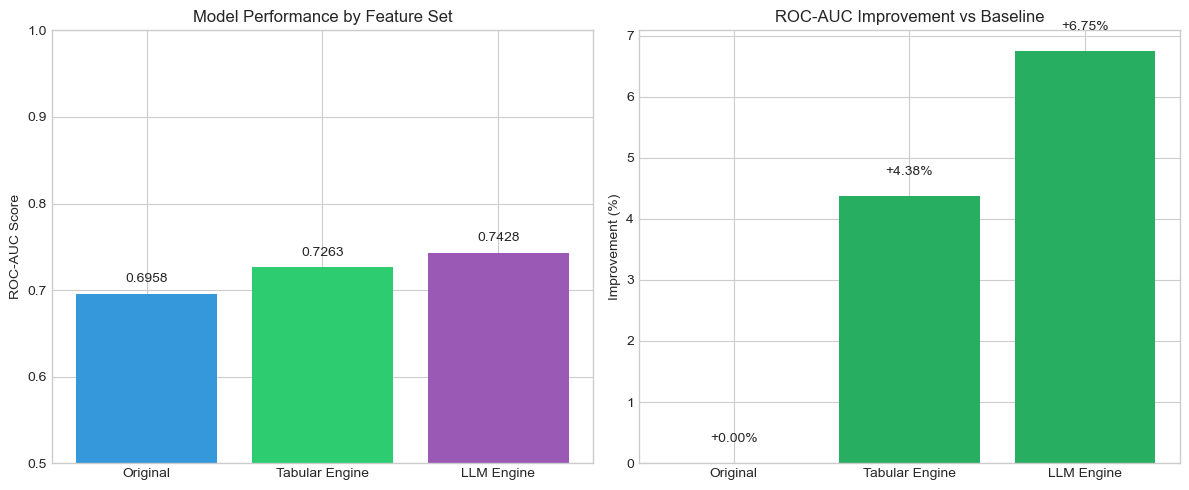

In [16]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC-AUC comparison
ax = axes[0]
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = ax.bar(results_df.index, results_df['roc_auc'], color=colors)
ax.set_ylabel('ROC-AUC Score')
ax.set_title('Model Performance by Feature Set', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.0])
for bar, auc in zip(bars, results_df['roc_auc']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{auc:.4f}', 
            ha='center', va='bottom', fontweight='bold')

# Improvement percentage
ax = axes[1]
improvements = results_df['improvement_auc']
colors_imp = ['#95a5a6' if x <= 0 else '#27ae60' for x in improvements]
bars = ax.bar(results_df.index, improvements, color=colors_imp)
ax.set_ylabel('Improvement (%)')
ax.set_title('ROC-AUC Improvement vs Baseline', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
for bar, imp in zip(bars, improvements):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{imp:+.2f}%', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. AutoML Training with FLAML

Let's use FLAML to find the best model with our engineered features.

In [17]:
try:
    from flaml import AutoML
    FLAML_AVAILABLE = True
    print("FLAML is available!")
except ImportError:
    FLAML_AVAILABLE = False
    print("FLAML not installed. Install with: pip install flaml[automl]")

FLAML is available!


In [18]:
if FLAML_AVAILABLE:
    flaml_results = {}
    
    for name, (X_tr, X_te) in datasets.items():
        print(f"\n{'='*50}")
        print(f"Training FLAML AutoML with {name} features...")
        print(f"{'='*50}")
        
        automl = AutoML()
        automl.fit(
            X_tr, y_train,
            task='classification',
            metric='roc_auc',
            time_budget=180,
            verbose=0,
        )
        
        pred = automl.predict(X_te)
        prob = automl.predict_proba(X_te)[:, 1]
        
        flaml_results[name] = {
            'accuracy': accuracy_score(y_test, pred),
            'roc_auc': roc_auc_score(y_test, prob),
            'best_model': automl.best_estimator,
            'n_features': X_tr.shape[1]
        }
        
        print(f"  Best model: {automl.best_estimator}")
        print(f"  ROC-AUC: {flaml_results[name]['roc_auc']:.4f}")


Training FLAML AutoML with Original features...
  Best model: catboost
  ROC-AUC: 0.7987


No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. Mor


FLAML AutoML RESULTS
               accuracy   roc_auc improvement_auc best_model
Original           0.75  0.816571             0.0   catboost
Tabular Engine   0.7375   0.80696          -1.177   catboost
LLM Engine       0.7225  0.798677       -2.191297   catboost


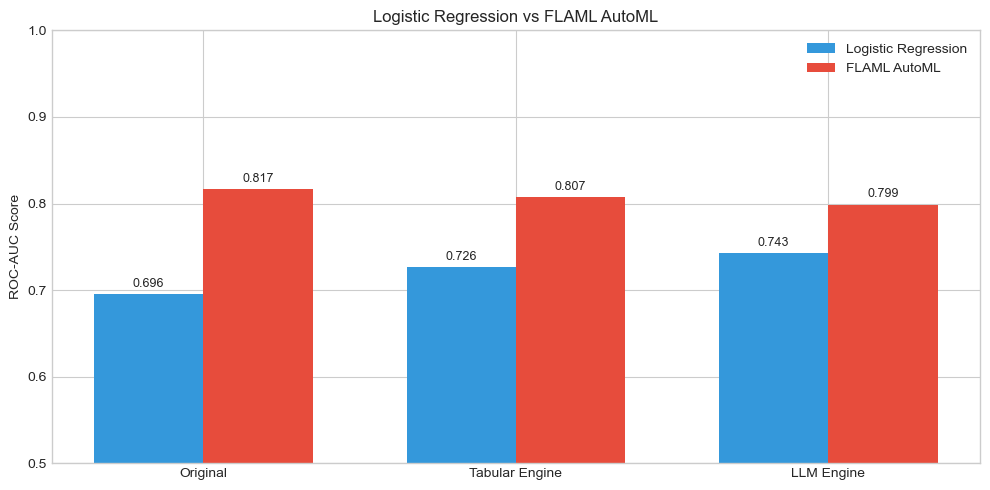

In [19]:
if FLAML_AVAILABLE:
    # Display FLAML results
    flaml_df = pd.DataFrame(flaml_results).T
    flaml_df['improvement_auc'] = ((flaml_df['roc_auc'] / flaml_df.loc['Original', 'roc_auc']) - 1) * 100
    
    print("\n" + "="*70)
    print("FLAML AutoML RESULTS")
    print("="*70)
    print(flaml_df[['accuracy', 'roc_auc', 'improvement_auc', 'best_model']].to_string())
    
    # Visualize FLAML results
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = np.arange(len(datasets))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['roc_auc'], width, label='Logistic Regression', color='#3498db')
    bars2 = ax.bar(x + width/2, flaml_df['roc_auc'], width, label='FLAML AutoML', color='#e74c3c')
    
    ax.set_ylabel('ROC-AUC Score')
    ax.set_title('Logistic Regression vs FLAML AutoML', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets.keys())
    ax.legend()
    ax.set_ylim([0.5, 1.0])
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('flaml_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Feature Store Integration with Feast

Save engineered features to Feast for reuse and serving.

In [20]:
try:
    from featcopilot.stores import FeastFeatureStore
    import feast  # Also check if feast is actually installed
    FEAST_AVAILABLE = True
    print("✓ Feast integration is available!")
except ImportError:
    FEAST_AVAILABLE = False
    print("⚠ Feast not installed. Install with: pip install featcopilot[feast]")
    print("  Skipping feature store integration.")

✓ Feast integration is available!


In [21]:
if FEAST_AVAILABLE:
    # Prepare data with entity columns
    X_train_feast = X_train_llm.copy()
    X_train_feast['patient_id'] = data.loc[X_train.index, 'patient_id'].values
    X_train_feast['event_timestamp'] = data.loc[X_train.index, 'event_timestamp'].values
    
    print(f"Features to save: {X_train_feast.shape[1] - 2} (excluding entity columns)")

Features to save: 56 (excluding entity columns)


In [22]:
if FEAST_AVAILABLE:
    # Initialize Feast Feature Store
    store = FeastFeatureStore(
        repo_path='./demo_feature_repo',
        project_name='diabetes_prediction',
        entity_columns=['patient_id'],
        timestamp_column='event_timestamp',
        ttl_days=365,
        auto_materialize=True,
        tags={'team': 'ml', 'domain': 'healthcare', 'created_by': 'featcopilot'}
    )
    
    store.initialize()
    print("Feast feature store initialized!")

Feast feature store initialized!


In [23]:
if FEAST_AVAILABLE:
    # Save features to Feast
    store.save_features(
        df=X_train_feast,
        feature_view_name='diabetes_features',
        description='Diabetes prediction features generated by FeatCopilot LLM engine'
    )
    
    print("✅ Features saved to Feast!")

✅ Features saved to Feast!


In [24]:
if FEAST_AVAILABLE:
    # List feature views
    views = store.list_feature_views()
    print(f"\nFeature views in store: {views}")
    
    # Get schema
    schema = store.get_feature_view_schema('diabetes_features')
    print(f"\nFeature view schema:")
    print(f"  - Name: {schema.get('name')}")
    print(f"  - Entities: {schema.get('entities')}")
    print(f"  - TTL: {schema.get('ttl')}")
    print(f"  - Features: {len(schema.get('features', []))} features")
    
    # Show first few features
    print(f"\n  Sample features:")
    for feat in schema.get('features', [])[:5]:
        print(f"    - {feat['name']}: {feat['dtype']}")


Feature views in store: ['diabetes_features']

Feature view schema:
  - Name: diabetes_features
  - Entities: ['patient_id']
  - TTL: 365 days, 0:00:00
  - Features: 57 features

  Sample features:
    - cholesterol_total_x_hba1c: Float64
    - bp_diastolic_x_glucose_fasting: Float64
    - bp_systolic_x_cholesterol_hdl: Float64
    - glucose_hba1c_product: Float64
    - exercise_hours_weekly_pow2: Float64


In [25]:
if FEAST_AVAILABLE:
    # Retrieve features for inference (online store)
    sample_patients = {'patient_id': [1, 2, 3, 4, 5]}
    
    # Get feature names (first 5)
    feature_names = [c for c in X_train_feast.columns if c not in ['patient_id', 'event_timestamp']][:5]
    
    online_features = store.get_online_features(
        entity_dict=sample_patients,
        feature_names=feature_names,
        feature_view_name='diabetes_features'
    )
    
    print("\n" + "="*50)
    print("ONLINE FEATURE RETRIEVAL (Real-time Inference)")
    print("="*50)
    print(f"\nRetrieved features for patients {sample_patients['patient_id']}:")
    for key, values in online_features.items():
        print(f"  {key}: {values}")


ONLINE FEATURE RETRIEVAL (Real-time Inference)

Retrieved features for patients [1, 2, 3, 4, 5]:
  patient_id: [1, 2, 3, 4, 5]
  exercise_hours_weekly: [4.53294330887546, None, 1.6864809009504176, 1.9587940293427066, 7.825821740606322]
  bmi: [23.928823987811544, None, 25.83012833388606, 39.80739365756881, 28.112681825898697]
  glucose_fasting: [127.84747946871306, None, 115.34610875041788, 143.26539457952896, 151.00322434084507]
  hba1c: [5.887873594368265, None, 5.9514232893528485, 6.847835209385528, 4.852135556045907]
  cholesterol_hdl: [47.347172598875765, None, 61.32010011612723, 50.92758622587276, 49.12207210904837]


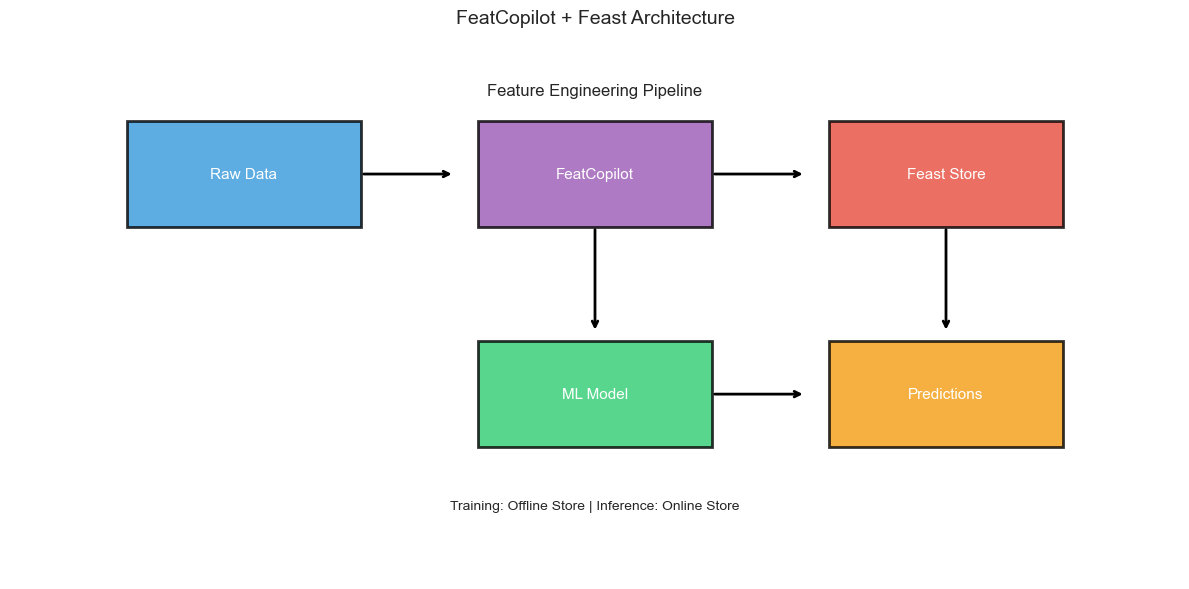

In [26]:
if FEAST_AVAILABLE:
    # Visualize feature store architecture
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create a simple architecture diagram using matplotlib
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis('off')
    ax.set_title('FeatCopilot + Feast Architecture', fontsize=14, fontweight='bold', pad=20)
    
    # Boxes
    boxes = [
        (1, 4, 2, 1.2, 'Raw Data', '#3498db'),
        (4, 4, 2, 1.2, 'FeatCopilot', '#9b59b6'),
        (7, 4, 2, 1.2, 'Feast Store', '#e74c3c'),
        (4, 1.5, 2, 1.2, 'ML Model', '#2ecc71'),
        (7, 1.5, 2, 1.2, 'Predictions', '#f39c12'),
    ]
    
    for x, y, w, h, label, color in boxes:
        rect = plt.Rectangle((x, y), w, h, facecolor=color, edgecolor='black', linewidth=2, alpha=0.8)
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    
    # Arrows
    arrows = [
        (3, 4.6, 0.8, 0),
        (6, 4.6, 0.8, 0),
        (5, 4, 0, -1.2),
        (8, 4, 0, -1.2),
        (6, 2.1, 0.8, 0),
    ]
    
    for x, y, dx, dy in arrows:
        ax.annotate('', xy=(x+dx, y+dy), xytext=(x, y),
                   arrowprops=dict(arrowstyle='->', color='black', lw=2))
    
    # Labels
    ax.text(5, 5.5, 'Feature Engineering Pipeline', ha='center', fontsize=12, style='italic')
    ax.text(5, 0.8, 'Training: Offline Store | Inference: Online Store', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('feast_architecture.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()

In [27]:
if FEAST_AVAILABLE:
    # Cleanup
    store.close()
    print("Feature store connection closed.")

Feature store connection closed.


## 10. Summary & Key Takeaways

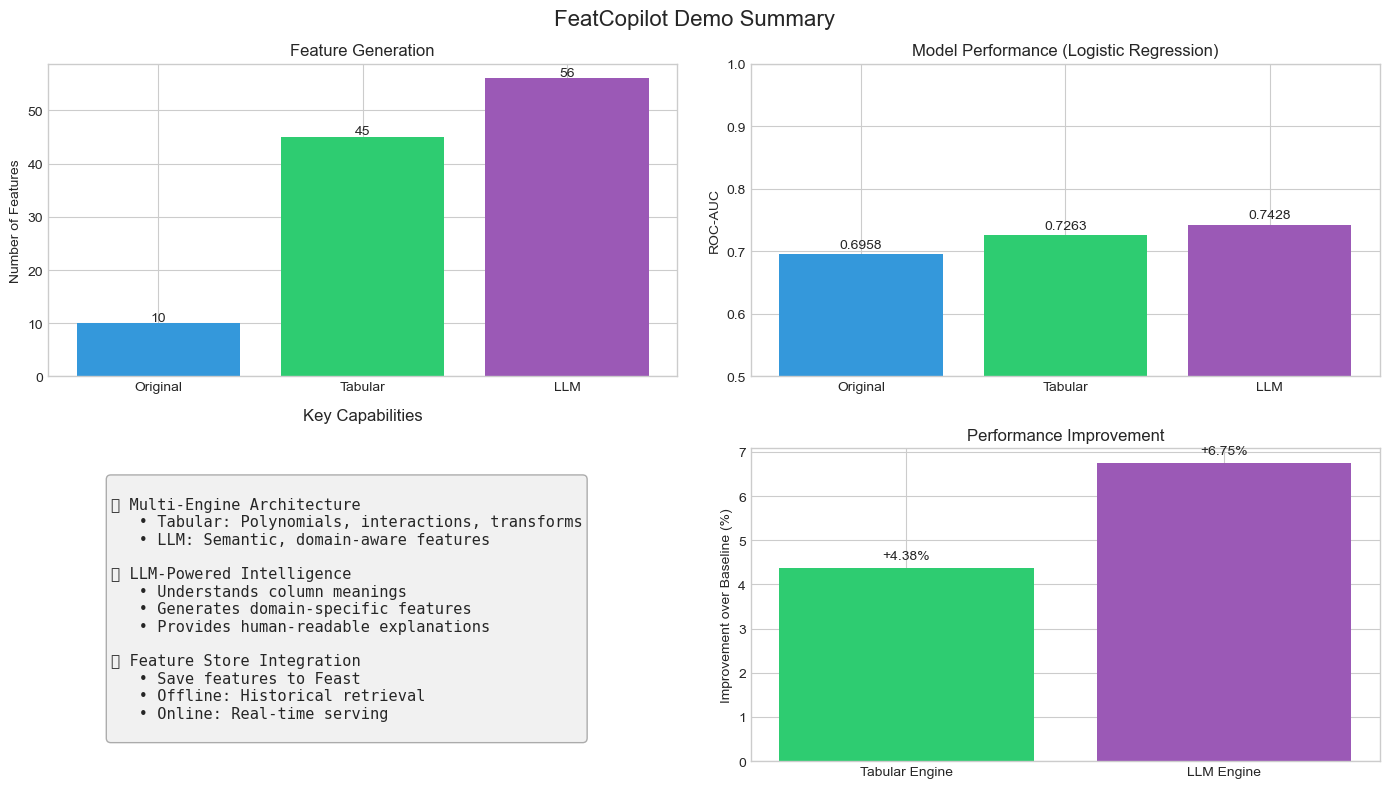

In [28]:
# Final summary visualization
fig = plt.figure(figsize=(14, 8))

# Create summary metrics
summary_data = {
    'Metric': ['Original Features', 'Tabular Features', 'LLM Features',
               'Baseline AUC', 'Tabular AUC', 'LLM AUC'],
    'Value': [X_train.shape[1], X_train_tabular.shape[1], X_train_llm.shape[1],
              results['Original']['roc_auc'], results['Tabular Engine']['roc_auc'], 
              results['LLM Engine']['roc_auc']]
}

# Main title
fig.suptitle('FeatCopilot Demo Summary', fontsize=16, fontweight='bold', y=0.98)

# Subplot 1: Feature generation
ax1 = fig.add_subplot(2, 2, 1)
methods = ['Original', 'Tabular', 'LLM']
features = [X_train.shape[1], X_train_tabular.shape[1], X_train_llm.shape[1]]
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = ax1.bar(methods, features, color=colors)
ax1.set_ylabel('Number of Features')
ax1.set_title('Feature Generation', fontweight='bold')
for bar, f in zip(bars, features):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(f), ha='center', fontweight='bold')

# Subplot 2: Model performance
ax2 = fig.add_subplot(2, 2, 2)
aucs = [results['Original']['roc_auc'], results['Tabular Engine']['roc_auc'], results['LLM Engine']['roc_auc']]
bars = ax2.bar(methods, aucs, color=colors)
ax2.set_ylabel('ROC-AUC')
ax2.set_title('Model Performance (Logistic Regression)', fontweight='bold')
ax2.set_ylim([0.5, 1.0])
for bar, a in zip(bars, aucs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{a:.4f}', ha='center', fontweight='bold')

# Subplot 3: Key capabilities
ax3 = fig.add_subplot(2, 2, 3)
ax3.axis('off')
capabilities = """
🔧 Multi-Engine Architecture
   • Tabular: Polynomials, interactions, transforms
   • LLM: Semantic, domain-aware features

🤖 LLM-Powered Intelligence
   • Understands column meanings
   • Generates domain-specific features
   • Provides human-readable explanations

📊 Feature Store Integration
   • Save features to Feast
   • Offline: Historical retrieval
   • Online: Real-time serving
"""
ax3.text(0.1, 0.9, capabilities, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))
ax3.set_title('Key Capabilities', fontweight='bold', pad=20)

# Subplot 4: Improvement summary
ax4 = fig.add_subplot(2, 2, 4)
improvements = [
    results_df.loc['Tabular Engine', 'improvement_auc'],
    results_df.loc['LLM Engine', 'improvement_auc']
]
methods_imp = ['Tabular Engine', 'LLM Engine']
colors_imp = ['#2ecc71', '#9b59b6']
bars = ax4.bar(methods_imp, improvements, color=colors_imp)
ax4.set_ylabel('Improvement over Baseline (%)')
ax4.set_title('Performance Improvement', fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
for bar, imp in zip(bars, improvements):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'+{imp:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('featcopilot_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
print("\n" + "="*70)
print("📊 FEATCOPILOT DEMO SUMMARY")
print("="*70)
print(f"""
Dataset: Synthetic Diabetes Prediction ({len(data)} samples)

Feature Engineering Results:
  • Original features:      {X_train.shape[1]}
  • Tabular engine:         {X_train_tabular.shape[1]} features
  • LLM engine:             {X_train_llm.shape[1]} features

Model Performance (Logistic Regression):
  • Baseline ROC-AUC:       {results['Original']['roc_auc']:.4f}
  • Tabular ROC-AUC:        {results['Tabular Engine']['roc_auc']:.4f} ({results_df.loc['Tabular Engine', 'improvement_auc']:+.2f}%)
  • LLM ROC-AUC:            {results['LLM Engine']['roc_auc']:.4f} ({results_df.loc['LLM Engine', 'improvement_auc']:+.2f}%)

Key Takeaways:
  ✅ FeatCopilot automatically generates predictive features
  ✅ LLM engine provides semantic understanding and explanations
  ✅ Feature store integration enables production deployment
  ✅ Works seamlessly with AutoML (FLAML)
""")
print("="*70)


📊 FEATCOPILOT DEMO SUMMARY

Dataset: Synthetic Diabetes Prediction (2000 samples)

Feature Engineering Results:
  • Original features:      10
  • Tabular engine:         45 features
  • LLM engine:             56 features

Model Performance (Logistic Regression):
  • Baseline ROC-AUC:       0.6958
  • Tabular ROC-AUC:        0.7263 (+4.38%)
  • LLM ROC-AUC:            0.7428 (+6.75%)

Key Takeaways:
  ✅ FeatCopilot automatically generates predictive features
  ✅ LLM engine provides semantic understanding and explanations
  ✅ Feature store integration enables production deployment
  ✅ Works seamlessly with AutoML (FLAML)



---

## 🎉 Conclusion

This notebook demonstrated FeatCopilot's key capabilities:

1. **Tabular Engine**: Fast feature generation (<1s) with polynomials, interactions, and transforms
2. **LLM Engine**: Semantic understanding for domain-aware feature creation with explanations
3. **Feature Store**: Feast integration for feature reuse and serving
4. **AutoML**: Seamless integration with FLAML for automated model selection

### Next Steps

- Try FeatCopilot on your own datasets
- Explore different LLM backends (OpenAI, Anthropic, etc.)
- Deploy features to production with Feast
- Combine with your favorite ML frameworks

📚 **Documentation**: [https://thinkall.github.io/featcopilot/](https://thinkall.github.io/featcopilot/)